# Monte Carlo sampling methods

Monte Carlo methods' great strength is that they scale well in the dimensionality of the problem. Their great weakness is that they scale poorly for high accuracy: their standard error scales as $1 / \sqrt n$ in the number of samples $n$.

This notebook shows these sampling methods:
- Simple Monte Carlo
- Rejection sampling
- Importance sampling
- Markov Chain Monte Carlo (MCMC) - tbd

as well as the Bootstrap resampling method of Bradley Efron.

In [2]:
# Setup
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import matplotlib

In [3]:
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

## Simple Monte Carlo

In [4]:
def estimate_pi(n=10**4):
    x, y = np.random.uniform(size=(2, n))
    return (x**2+y**2 < 1).mean() * 4

In [5]:
estimate_pi()

3.1248

In [6]:
from statistics import stdev

In [7]:
import time
def rate_speed_and_accuracy(estimator, num_calls):
    """
    Time how long a sampling estimator takes and how accurate it is.
    
    Parameters
    ----------
    estimator : function
        A function to call
        
    num_calls : 1d sequence (array, tuple, or list)
        How many times to call estimator() before logging stats.
        Example: (10, 100, 1000, 10000, 100000)
        
    Returns
    -------
    a dictionary {n: {'time': ..., 'stdev': ...}, ...} with time and accuracy stats
    for each value of n in num_calls.
    """
    
    start = time.time()
    from collections import defaultdict
    stats = defaultdict(dict)
    for n in num_calls:
        print(n)
        estimates = (estimator() for _ in range(n))
        stats[n]['accuracy'] = stdev(estimates) / n**0.5
        stats[n]['time'] = time.time() - start
    return stats

In [8]:
num_calls = (10, 100, 1000, 10000, 100000)

In [9]:
stats1 = rate_speed_and_accuracy(estimate_pi, num_calls)

10
100
1000
10000
100000


In [10]:
stats1

defaultdict(dict,
            {10: {'accuracy': 0.0035139341674728848,
              'time': 0.008582115173339844},
             100: {'accuracy': 0.001743573434998458,
              'time': 0.1365339756011963},
             1000: {'accuracy': 0.0005143215329725939,
              'time': 1.0876221656799316},
             10000: {'accuracy': 0.00016409646390921025,
              'time': 8.770204305648804},
             100000: {'accuracy': 5.185965842291788e-05,
              'time': 52.802300214767456}})

## More efficient sampling

If the point is in the lower left triangle, reflect it in the line $y = 1 - x$:

In [11]:
x, y = np.random.uniform(size=(2, 10**3))

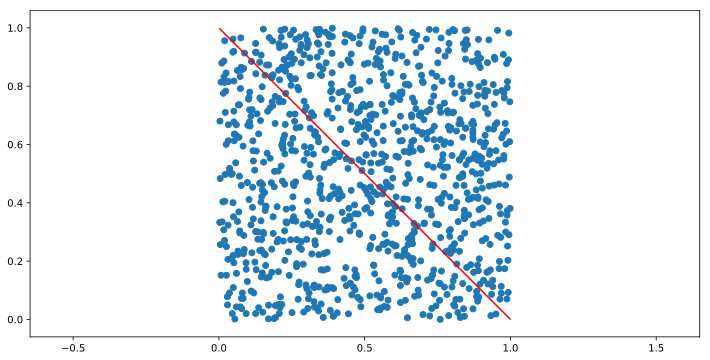

In [12]:
plt.scatter(x, y)
plt.plot(x, 1-x, color='red', linestyle='-')
plt.axis('equal');

In [13]:
x, y = np.where(x + y < 1, np.vstack([1-y, 1-x]), np.vstack([x, y]))

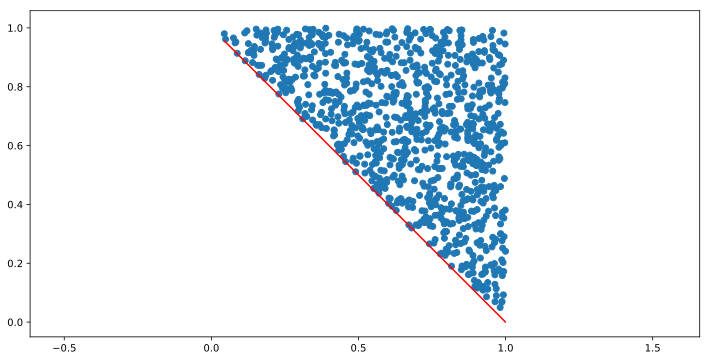

In [14]:
plt.scatter(x, y)
plt.plot(x, 1-x, color='red', linestyle='-')
plt.axis('equal');

### Exercise: write `estimate_pi_efficient()` and see how quickly it converges versus the other one.

In [15]:
def estimate_pi_efficient(n=10**4):
    x, y = np.random.uniform(size=(2, n))
    num_in_triangle = (x + y < 1).sum()
    x, y = np.where(x + y < 1, np.vstack([1 - x, 1 - y]), np.vstack([x, y]))
    return (1 + (x**2 + y**2 < 1).mean()) * 2

In [16]:
estimate_pi_efficient()

3.1315999999999997

In [17]:
stats2 = rate_speed_and_accuracy(estimate_pi_efficient, num_calls)

10
100
1000
10000
100000


In [18]:
stats2

defaultdict(dict,
            {10: {'accuracy': 0.0032786175948611718,
              'time': 0.019659996032714844},
             100: {'accuracy': 0.0008444543752738754,
              'time': 0.14449715614318848},
             1000: {'accuracy': 0.0003220465323039032,
              'time': 1.7174110412597656},
             10000: {'accuracy': 9.891063920233627e-05,
              'time': 9.476948022842407},
             100000: {'accuracy': 3.135320618219481e-05,
              'time': 93.45570516586304}})

In [19]:
import pandas as pd
df1 = pd.DataFrame(stats1).T.rename(columns={'accuracy': 'basic'})
df1

,basic,time
10,0.003514,0.008582
100,0.001744,0.136534
1000,0.000514,1.087622
10000,0.000164,8.770204
100000,0.000052,52.802300


In [20]:
df2 = pd.DataFrame(stats2).T.rename(columns={'accuracy': 'efficient'})
df2

,efficient,time
10,0.003279,0.019660
100,0.000844,0.144497
1000,0.000322,1.717411
10000,0.000099,9.476948
100000,0.000031,93.455705


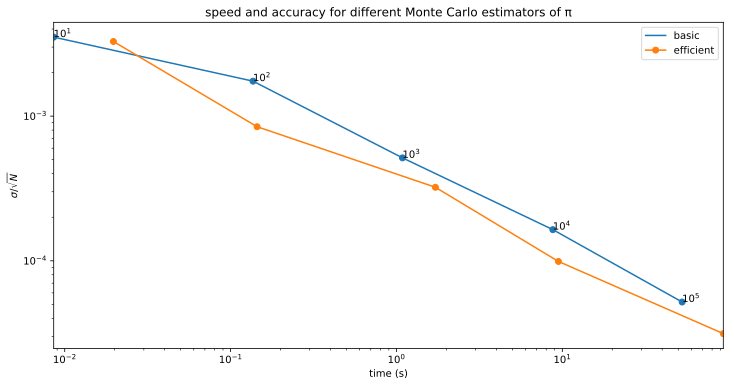

In [21]:
ax = df1.plot('time', 'basic', logx=True, logy=True, marker='o')
df2.plot('time', 'efficient', logx=True, logy=True, marker='o', ax=ax)

#ax = df.plot(['time', 'time2'], ['basic', 'efficient'], logx=True, marker='o')
plt.title('speed and accuracy for different Monte Carlo estimators of π')
plt.ylabel(r'$\sigma / \sqrt{N}$')
plt.xlabel('time (s)')
for i, n in enumerate(df1.index):
    plt.text(df1.iloc[i]['time'], df1.iloc[i]['basic'], f'$10^{int(np.log10(n))}$')
#df2.T.plot('time', 'stdev', logx=True, logy=True, ax=ax)

## Rejection sampling

Consider sampling from this (unnormalized) density:

$P^∗(x)=\exp \left[ 0.4(x−0.4)^2−0.08x^4\right]$

In [38]:
def P_star(x):
    return np.exp((0.4 * (x-0.4)**2) - 0.08 * x**4)

This looks like this:

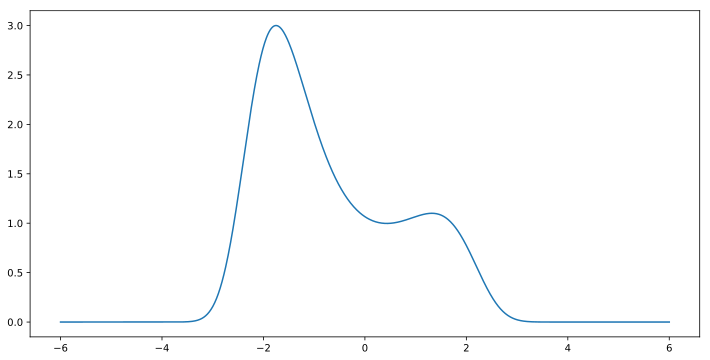

In [39]:
x = np.linspace(-6, 6, num=1000)
plt.plot(x, P_star(x))

#How can we sample from $P^*$? 

In [ ]:
Rejection sampling gives us one way to do this. The steps are:

1. Propose a different density $Q$ which we can evaluate and from which we can evaluate samples.
2. Assume we know a constant $c$ such that $c Q^*(x) > P^*(x)$ for all $x$.

In [40]:
# larger than P_star(x) for all x
def Q_star(x):
    return scipy.stats.norm(-1.2, 2).pdf(x)

In [41]:
def Q_star_gen(n=1):
    """
    Sample n points from from the distribution with density Q*(x)
    """
    return scipy.stats.norm(-1.2, 2).rvs(n)

In [42]:
Q_star_gen(5)

array([-3.3428924 , -2.21290835,  0.48980384, -1.87926332, -0.86884641])

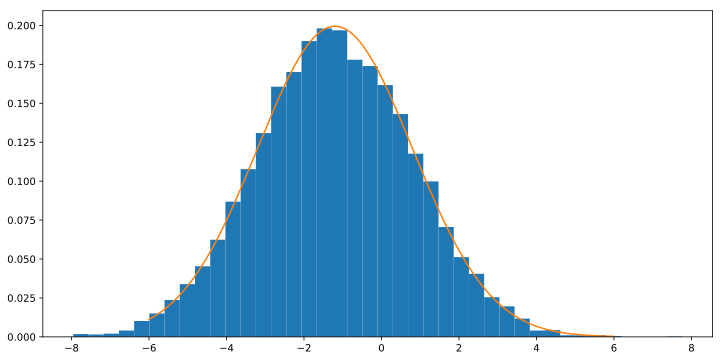

In [43]:
plt.hist(Q_star_gen(10**4), bins=40, normed=True)
plt.plot(x, Q_star(x));

In [44]:
from scipy.optimize import basinhopping

In [45]:
def find_multiplier(p, q, ndim=1):
    """
    Finds a constant multipler $c$ such that $c q(x) > p(x)$ for all values $x \in R^{ndim}$. 
    
    Parameters
    ----------
    p : function
        Probability density (perhaps unnormalized)
    
    q : function
        Another probability density (perhaps unnormalized)
    
    ndim : integer
        Number of dimensions
    
    """
    def q_over_p(x):
        return q(x) / p(x)
    
    result = basinhopping(q_over_p, np.zeros(ndim))
    return 1 / result.fun   # return the p(x) / q(x) ratio that 

In [46]:
c = find_multiplier(P_star, Q_star)
c

15.701198125854797

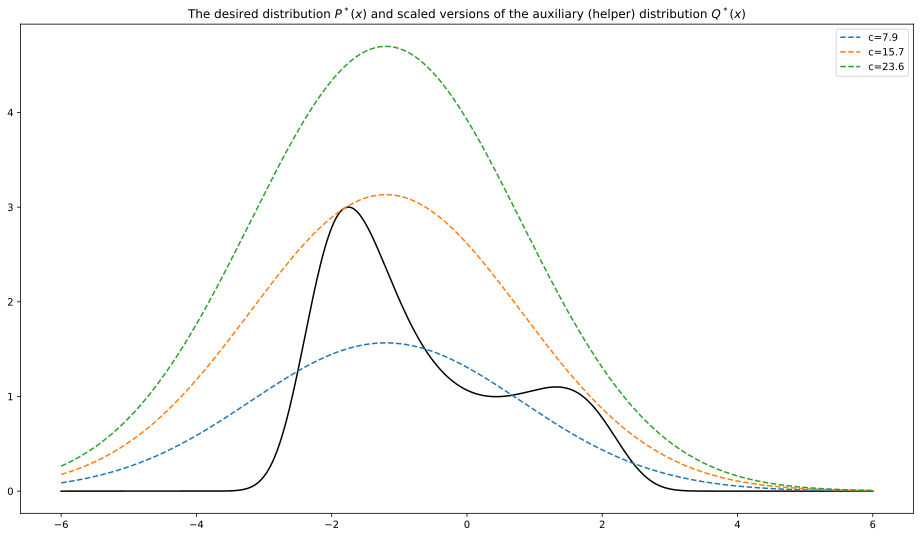

In [47]:
plt.figure(figsize=(16, 9))
plt.plot(x, P_star(x), color='black')
plt.plot(x, 0.5 * c * Q_star(x), label=f'c={0.5*c:.1f}', linestyle='dashed')
plt.plot(x, c * Q_star(x), label=f'c={c:.1f}', linestyle='dashed')
plt.plot(x, 1.5 * c * Q_star(x), label=f'c={1.5*c:.1f}', linestyle='dashed')
plt.legend()
plt.title('The desired distribution $P^*(x)$ and scaled versions of the auxiliary (helper) distribution $Q^*(x)$');

This value of $c$ is the threshold above which this condition holds: $c Q^*(x) > P^*(x)$ for all $x$.

In [48]:
c

15.701198125854797

In [49]:
np.all(0.999 * c * Q_star(x) > P_star(x))

False

In [50]:
np.all(1.001 * c * Q_star(x) > P_star(x))

True

Now we can proceed with rejection sampling as follows:

In [51]:
# Algorithm:
# 1. Generate a value x from Q_star
# 2. Generate a uniform variate u on the interval [0, c Q*(x)]
# 3. If u > P ∗(x) then x is rejected; otherwise it is accepted, which means that we add x to our set of samples {x(r)}

In [52]:
n = 10**6
xs = Q_star_gen(n)
us = scipy.stats.uniform(0, c * Q_star(xs)).rvs(n)
np.c_[xs[:3], us[:3]]

array([[-0.49730181,  2.02776167],
       [-4.35366342,  0.36873229],
       [ 1.6756634 ,  0.73105337]])

In [53]:
P_star(xs[:3])

array([  1.37323226e+00,   2.77512217e-09,   1.02041162e+00])

In [54]:
accept = us < P_star(xs)

In [55]:
accept.mean()

0.49922

If the mean acceptance ratio is too small, sampling will take too long. The closer to 1, the better.

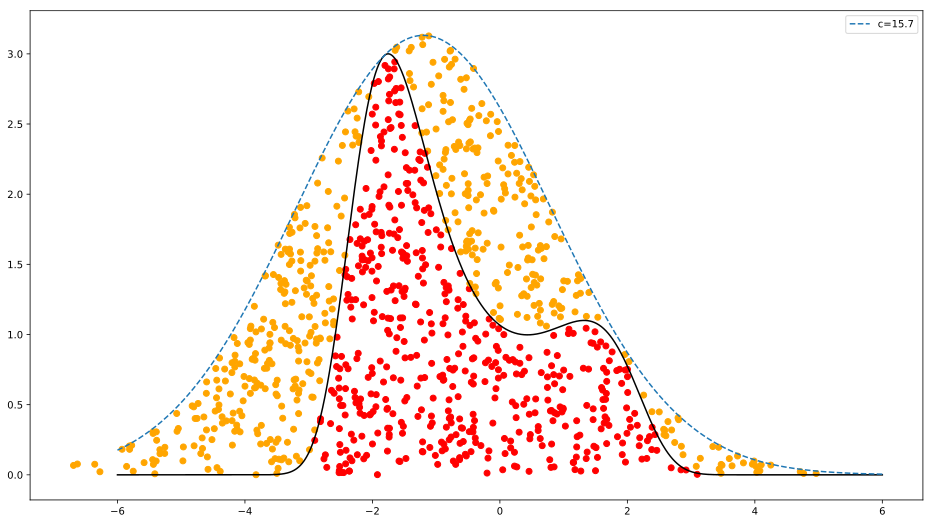

In [56]:
plt.figure(figsize=(16, 9))
plt.plot(x, P_star(x), color='black')
plt.plot(x, c * Q_star(x), label=f'c={c:.1f}', linestyle='dashed')
plt.scatter(xs[:1000], us[:1000], c=['red' if accept[i] else 'orange' for i in range(n)])
plt.legend()
#plt.title('The desired distribution $P^*(x)$ and scaled versions of the auxiliary (helper) distribution $Q^*(x)$')

Check the first accepted $x$ value:

In [57]:
accept[:6]

array([False, False,  True,  True,  True, False], dtype=bool)

In [58]:
xs[:6]

array([-0.49730181, -4.35366342,  1.6756634 ,  1.61683437, -1.08899399,
       -3.12604374])

Now we choose the portion of the sample that was accepted:

In [118]:
sample = xs[accept]
sample[0]

1.675663395775272

In [170]:
def rejection_sample(p_star, q_star, q_gen, n=10**4):
    """
    Algorithm:
    1. Generate a value x from Q_star
    2. Generate a uniform variate u on the interval [0, c Q*(x)]
    3. If u > P ∗(x) then x is rejected; otherwise it is accepted, which means that we add x to our set of samples {x(r)}
    
    Returns
    -------
        Returns the given sample (of length m < n).
    """
    xs = q_gen(n)
    us = scipy.stats.uniform(0, c * q_star(xs)).rvs(n)
    accept = us < p_star(xs)
    accepted_sample = xs[accept]
    return accepted_sample

In [171]:
n = 10**4
sample = rejection_sample(P_star, Q_star, Q_star_gen, n=n)

The acceptance ratio was:

In [172]:
len(sample) / n

0.5032

### Check: does the sample from $P^*(x)$ look reasonable?

Notice that this is at the first index `i` for which `accept[i] == True`.

In [173]:
len(sample)

5032

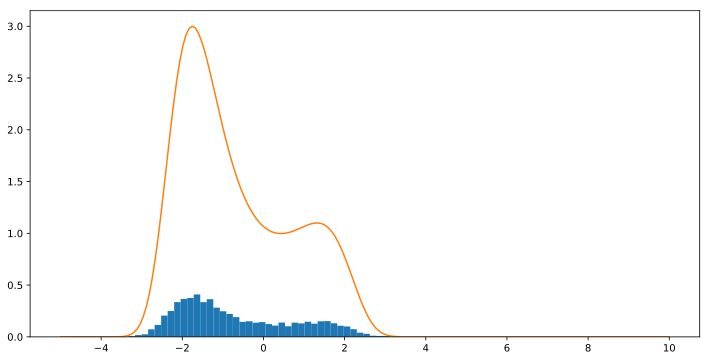

In [174]:
plt.hist(sample, bins=40, normed=True)
plt.plot(x, P_star(x))

Remember that $P^*(x)$ was unnormalized. What is the normalization constant?

In [175]:
from scipy.integrate import nquad

In [176]:
Z, abserr = nquad(P_star, [(-100, 100)])
Z

7.8521781788662155

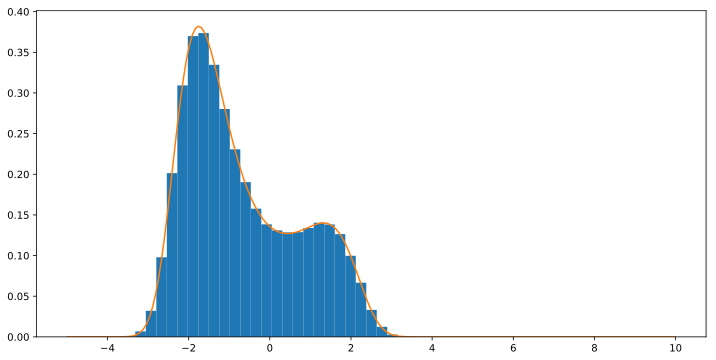

In [177]:
plt.hist(accepted_sample, bins=30, normed=True)
plt.plot(x, P_star(x) / Z)

## Importance sampling

Importance sampling is a method for estimating the expectation of a function $\phi(\mathbf{x})$ of the random variable, not for generating samples from $P(\mathbf{x})$.

Here is an example in 1d:

In [178]:
# unnormalized density: a mixture of 2 Gaussians
def P2_star(x):
    return (scipy.stats.norm(1, 1).pdf(x) +
            scipy.stats.norm(3, .5).pdf(x))

In [179]:
x = np.linspace(-5, 10, 200)

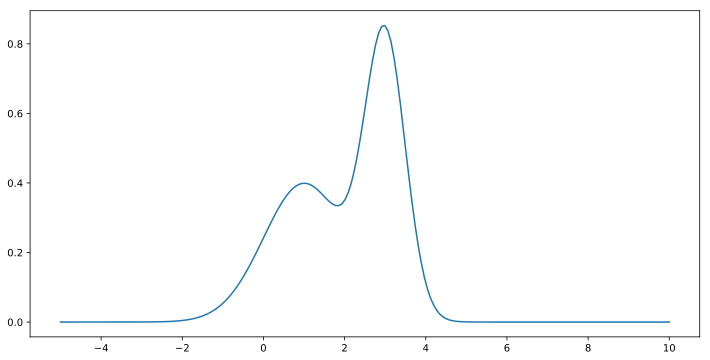

In [180]:
plt.plot(x, P2_star(x))

In general it is difficult to sample from an arbitrary probability distribution $P$. Importance sampling is a technique for estimating the expectation of certain statistics under a distribution $P$ by choosing or constructing a different distribution $Q$ that is simpler to sample from, and re-weighting accordingly.

Here is an example:

In [181]:
# larger than P2_star(x) for all x
def Q2_star(x):
    return 5 * scipy.stats.norm(2, 2).pdf(x)

We require that this be true in order for importance sampling to work:

In [233]:
np.all(Q2_star(x) >= P2_star(x))

True

Importance sampling also requires that $Q(x) > 0$ whenever $P(x) > 0$.

Is this true here?

In [242]:
assert np.count_nonzero((P2_star(x) > 0) & (Q2_star(x) <= 0)) == 0

Note that $P_2^*$ and $Q_2^*$ are unnormalized (improper) probability densities.

Now we generate samples from $Q_2(x)$:

In [202]:
def Q2_gen(n=10**6):
    return scipy.stats.norm(2, 2).rvs(n)

In [206]:
sample = Q2_gen()

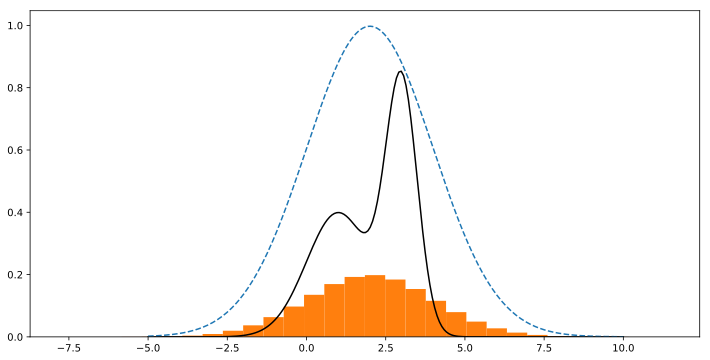

In [210]:
plt.plot(x, P2_star(x), color='black')
plt.plot(x, Q2_star(x), linestyle='dashed')
plt.hist(sample, bins=30, normed=True);

Now consider some function $\phi(x)$ whose expectation under $P$ we want to calculate.

Examples:
- expectation of $X$
- expectation of $X^2$
- $P(X < 1)$, which is the expectation of the indicator function:
    $$I(X < 1) = 1 \text{ if } X < 1$$
    $$I(X < 1) = 0 \text{ if } X >= 1$$

In [211]:
def phi(x):
    return x**2

We can estimate the expectation $E(\phi(X))$ as follows:

In [212]:
weights = P2_star(sample) / Q2_star(sample)
weights[:5]

array([ 0.36773594,  0.03794219,  0.42151654,  0.38505921,  0.47183735])

In [213]:
weights.min(), weights.max()

(5.4820968990985459e-20, 0.97006393448948414)

In [214]:
phi_estimator = weights @ phi(sample) / np.sum(weights)

In [215]:
weights @ phi(sample)

2255784.4909491912

In [216]:
sum([weights[i] * phi(sample[i]) for i in range(len(sample))])

2255784.4909492056

In [217]:
phi_estimator

5.6365154989968476

### Test

Is this a good estimate for the expectation of $X^2$ under $P$?

We can check this by first using rejection sampling to draw a sample from $P$.

In [221]:
n = 10**7
xs = rejection_sample(P2_star, Q2_star, Q2_gen, n=n)

In [222]:
len(xs)

254669

In [223]:
len(xs) / n

0.0254669

In [224]:
np.mean(xs**2)

5.6222858901670527

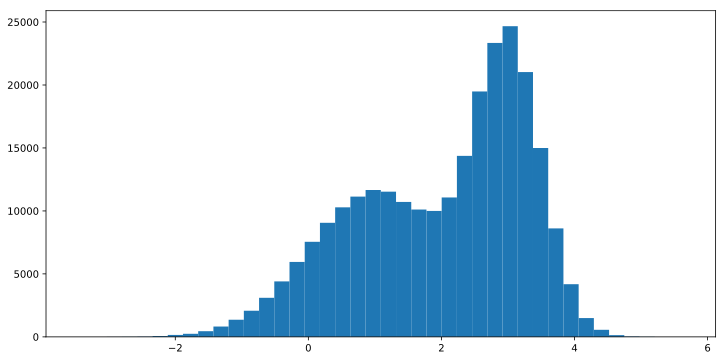

In [225]:
plt.hist(xs, bins=40);

In [243]:
def estimate_statistic_importance(statistic, p, q, q_gen, n=10**5, sanity_check=True):
    """
    Estimate of the expectation of the given statistic
    under the probability distribution with density p.
    
    Parameters
    ----------
    statistic : function
    
    p : function
        Probability density of the probability distribution of interest (perhaps unnormalized).
 
    q : function
        Probability density of an auxiliary distribution (perhaps unnormalized) that is easier
        to sample from than p.
    
    q_gen : function
        Function q_gen(n) with one argument n, the number of samples.
        Returns samples of n observations randomly from q.

    sanity_check : bool
        If True, ensure that q(x) > 0 whenever p(x) > 0.
        
    Returns
    -------
    An estimate of the statistic of interest under p.
    """
    sample = q_gen(n)
    if sanity_check:
        # Ensure q(x) > 0 whenever p(x) > 0:
        assert np.count_nonzero((p(sample) > 0) & (q(sample) <= 0)) == 0
    weights = p(sample) / q(sample)
    estimate = weights @ statistic(sample) / np.sum(weights)
    return estimate

In [229]:
estimate_statistic_importance(phi, P2_star, Q2_star, Q2_gen)

5.6384580227776846

In [79]:
def identity(x):
    return x

In [230]:
estimate_statistic_importance(identity, P2_star, Q2_star, Q2_gen)

1.9979805693815109

In [81]:
def estimate_statistic_easy(statistic, p, method='importance'):
    """
    A simple high-level interface to a bunch of Monte Carlo based estimators.
    """


## Bootstrap confidence intervals

This section shows the "Bootstrap" method of Bradley Efron for estimating confidence intervals.

In [82]:
def bootstrap_sampler(original_dataset, statistic, trials=10000):
    original_dataset = np.array(original_dataset)
    n = len(original_dataset)
    resamples = []
    for i in range(trials):
        indices = np.random.randint(n, size=n)
        resamples.append(statistic(original_dataset[indices]))
    return resamples

In [83]:
n = 100

In [84]:
data2 = np.random.normal(size=n)

In [85]:
medians = bootstrap_sampler(data2, np.median)

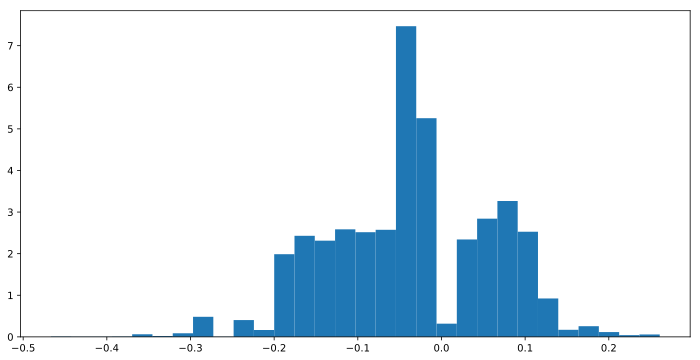

In [231]:
plt.hist(medians, bins=30, normed=True);

In [87]:
α = 0.05

In [88]:
def confidence_intervals(original_dataset, statistic, α=0.05, trials=10000):
    bootstrap_statistics = bootstrap_sampler(original_dataset, statistic, trials=trials)
    s = np.sort(bootstrap_statistics)
    lower = s[int((α/2.0)*trials)]
    upper = s[int((1-α/2.0)*trials)]
    return lower, upper

In [89]:
confidence_intervals(data2, np.median)

(-0.22722560069565889, 0.13164076427708477)